# This notebook classifies naturalized flows from all realizations according to several metrics on occurences of low flows

In [33]:
import os
import glob
import numpy as np
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import itertools
import matplotlib
import matplotlib.colors as colors
import copy

Read **naturalized** sampled flows for all realizations

In [34]:
# Read in sampled flows
generated_flows_wider = np.load('LHsamples_wider_100_AnnQonly_flows.npy')
all_annual_experiment_flows=np.sum(generated_flows_wider, axis=2)*1233.4818/1000000

samples = pd.read_csv('LHsamples_wider_100_AnnQonly.txt', header=0, delim_whitespace=True)

Read in **naturalized** historic flows

In [35]:
historic_flows = np.load('historic_flows.npy')
annual_historic_flows = np.sum(historic_flows, axis=1)*1233.4818/1000000
reference_bad_flow = np.min(annual_historic_flows)

Read in flows from other experiments

In [36]:
CMIP_flows = np.load('CMIP_SOWs_flows.npy')*1233.4818/1000000
stationary_flows = np.load('stationarysynthetic_flows.npy')*1233.4818/1000000
annual_CMIP_flows = np.sum(CMIP_flows, axis=2)
annual_stationary_flows = np.sum(stationary_flows, axis=2)

Function to count consecutive occurences

In [37]:
def count_max_flow_duration(sequence, flow):
    flow_occurence = [sequence[i]<=flow for i in range(len(sequence))] # Returns a list of True values where condition is met
    low_flows = sequence[flow_occurence]
    flow_duration = [ sum( 1 for _ in group ) for key, group in itertools.groupby( flow_occurence ) if key ] # Counts groups of True values
    return flow_duration, low_flows

In [38]:
flow_duration_list = []
low_flows_list = []
for j in range(len(all_annual_experiment_flows[:,0])):
    flow_duration, low_flows = count_max_flow_duration(all_annual_experiment_flows[j,:],
                                                       reference_bad_flow)
    flow_duration_list.append(flow_duration)
    low_flows_list.append(low_flows)
summary_occurences = [np.sum(flow_duration_list[j]) for j in range(len(all_annual_experiment_flows[:,0]))]
summary_occurences_order = np.argsort(summary_occurences)[::-1]
np.savetxt('realizations_order.txt', summary_occurences_order)

In [39]:
number_limit = 1000
x_values = list(np.arange(number_limit+1))
# Function that converts realization index to sample and realization
no_to_realization = lambda x: (int(x/10), (x-1)%10)
# Create dataframe of data to plot
max_flow = reference_bad_flow
min_flow = reference_bad_flow
max_duration = 1
min_duration = 1
flow_metrics = pd.DataFrame(columns = ['Low flow occurences X', 'Low flow occurences Y', 'Low flow colors',
                                       'Duration occurences X', 'Duration occurences Y', 'Duration colors', 
                                       'Flow mean', 'Flow variance', 'mu_dry', 'sigma_dry', 'mu_wet', 
                                       'sigma_wet', 'p_drydry','p_wetwet'])
for j, k in zip(summary_occurences_order[:number_limit], x_values):
    all_occurences = len(low_flows_list[j])
    duration_occurences = len(flow_duration_list[j])
    sample = no_to_realization(j)[0]
    flow_metrics = flow_metrics.append({'Low flow occurences X' : [x_values[k]] * all_occurences, 
                                        'Low flow occurences Y' : np.arange(all_occurences),
                                        'Low flow colors' : np.sort(low_flows_list[j]),
                                        'Duration occurences X' : [x_values[k]] * duration_occurences,
                                        'Duration occurences Y' : np.arange(duration_occurences),
                                        'Duration colors' : np.sort(flow_duration_list[j]),
                                        'Flow mean' : np.mean(all_annual_experiment_flows[j,:]),
                                        'Flow variance' : np.std(all_annual_experiment_flows[j,:]), 
                                        'mu_dry' : samples.at[sample,'mu_dry'], 
                                        'sigma_dry' : samples.at[sample,'sigma_dry'],
                                        'mu_wet' : samples.at[sample,'mu_wet'], 
                                        'sigma_wet' : samples.at[sample,'sigma_wet'],
                                        'p_drydry' : samples.at[sample,'p_drydry'], 
                                        'p_wetwet' : samples.at[sample,'p_wetwet']}, 
                                       ignore_index = True)
    if low_flows_list[j].any(): #only do this if array is not empty
        if min(low_flows_list[j]) < min_flow:
            min_flow=min(low_flows_list[j])
    if flow_duration_list[j]: #only do this if list is not empty
        if max(flow_duration_list[j]) > max_duration:
            max_duration=max(flow_duration_list[j])

Identify historic reference points

In [40]:
historic_occurence = count_max_flow_duration(annual_historic_flows,reference_bad_flow)[0]
for j, k in zip(summary_occurences_order[:number_limit], x_values):
    if flow_duration_list[j] == historic_occurence:
        reference_index = k
        break

Identify reference points for other experiments

In [47]:
#CMIP
flow_duration_list_CMIP = []
low_flows_list_CMIP = []
for j in range(len(annual_CMIP_flows[:,0])):
    flow_duration, low_flows = count_max_flow_duration(annual_CMIP_flows[j,:],
                                                       reference_bad_flow)
    flow_duration_list_CMIP.append(flow_duration)
    low_flows_list_CMIP.append(low_flows)
summary_occurences_CMIP = [np.sum(flow_duration_list_CMIP[j]) for j in range(len(annual_CMIP_flows[:,0]))]

for j, k in zip(summary_occurences_order[:number_limit], x_values):
    if np.sum(flow_duration_list[j]) == np.max(summary_occurences_CMIP):
        reference_index_CMIP = k
        break
        
reference_flows_CMIP = low_flows_list_CMIP[np.argmax(summary_occurences_CMIP)]

In [62]:
len(flow_duration_list_CMIP[np.argmax(summary_occurences_CMIP)]

[1, 1, 4, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 1, 1, 1]

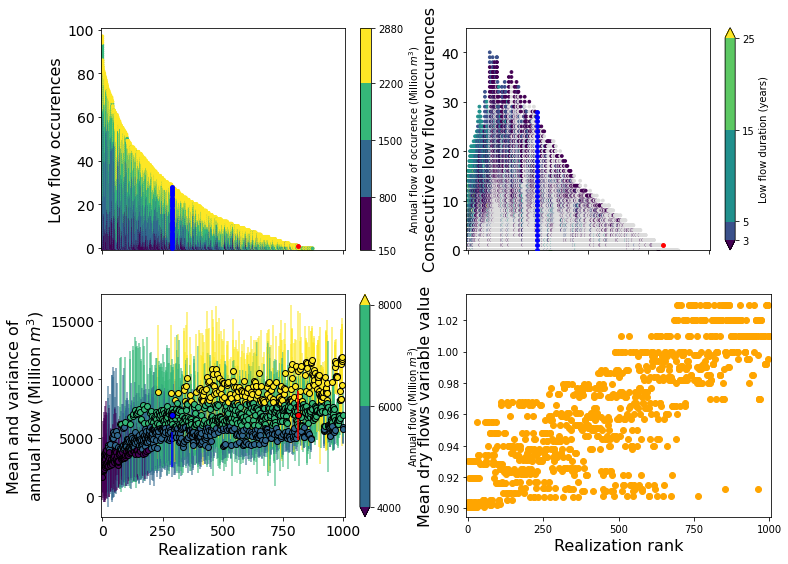

In [61]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12,9))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

flow_colormap = plt.cm.viridis 

duration_colormap = copy.copy(matplotlib.cm.get_cmap("viridis"))
duration_colormap.set_under('gainsboro', alpha=0.05)

flow_bounds = np.array([150, 800, 1500, 2200, max_flow])
normalize_flows = colors.BoundaryNorm(boundaries=flow_bounds, ncolors=256)

duration_bounds = np.array([2, 3, 5, 15, 25, max_duration])
normalize_durations = colors.BoundaryNorm(boundaries=duration_bounds, ncolors=256)

mean_flow_bounds = np.array([2000, 4000, 6000, 8000, 10000])
normalize_mean_flows = colors.BoundaryNorm(boundaries=mean_flow_bounds, ncolors=256)

# Plot all realizations
for index, row in flow_metrics.iterrows():
    low_flow_points = ax1.scatter(row['Low flow occurences X'], row['Low flow occurences Y'], 
                            s=30, c=row['Low flow colors'], marker = '.', alpha=1,
                            cmap=flow_colormap, norm=normalize_flows, zorder=1)

    dur_points = ax2.scatter(row['Duration occurences X'], row['Duration occurences Y'], 
                           s=30, c=row['Duration colors'], marker = '.', alpha=1,
                           cmap=duration_colormap, norm=normalize_durations, zorder=1)
    
    flow_std = ax3.errorbar(index, row['Flow mean'], yerr=row['Flow variance'], 
                            ecolor=flow_colormap(normalize_mean_flows(row['Flow mean'])), 
                            alpha = 0.7, zorder=1)
    
    flow_points = ax3.scatter(index, row['Flow mean'], c=row['Flow mean'], marker = 'o',  
                              edgecolors = 'black', linewidth=1, alpha=1, cmap=flow_colormap, 
                              norm=normalize_mean_flows, zorder=2)
    ax4.scatter(index, row['mu_dry'], marker = 'o', c='orange')

# Plot historic reference points
ax1.scatter(reference_index, 1, s=60, marker='.', c='red', zorder=2)
ax2.scatter(reference_index, 1, s=60, marker='.', c='red', zorder=2)
ax3.errorbar(reference_index, np.mean(annual_historic_flows), yerr=np.std(annual_historic_flows), 
             ecolor='red', zorder=3)
ax3.scatter(reference_index, np.mean(annual_historic_flows), marker = 'o',
            c='red', edgecolors = 'black', linewidth=1, alpha=1, zorder=4)

# Plot CMIP reference points
ax1.scatter([reference_index_CMIP]*len(reference_flows_CMIP), 
            np.arange(len(reference_flows_CMIP)), s=60, marker='.', c='blue', zorder=5)
ax2.scatter([reference_index_CMIP]*len(reference_flows_CMIP), 
            np.arange(np.max(summary_occurences_CMIP)), s=60, marker='.', c='blue', zorder=3)
ax3.errorbar(reference_index_CMIP, np.mean(annual_CMIP_flows[np.argmax(summary_occurences_CMIP),:]), 
             yerr=np.std(annual_CMIP_flows[np.argmax(summary_occurences_CMIP),:]), 
             ecolor='blue', zorder=4)
ax3.scatter(reference_index_CMIP, np.mean(annual_historic_flows), marker = 'o',
            c='blue', edgecolors = 'black', linewidth=1, alpha=1, zorder=5)

ax1.set_xlim([-5, number_limit+5])
ax2.set_xlim([-5, number_limit+5])
ax1.set_ylim([-1, 101]) 
ax2.set_ylim([0, 45])

ax1.set_ylabel("Low flow occurences", fontsize=16)
ax2.set_ylabel("Consecutive low flow occurences", fontsize=16)
ax3.set_ylabel("Mean and variance of\nannual flow (Million $m^3$)", fontsize=16)
ax4.set_ylabel("Mean dry flows variable value", fontsize=16)

ax3.set_xlabel("Realization rank", fontsize=16)
ax4.set_xlabel("Realization rank", fontsize=16)

ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)
ax3.tick_params(axis='both', labelsize=14)


fig.colorbar(low_flow_points, ax=ax1, boundaries = flow_bounds, 
             spacing='proportional', label = 'Annual flow of occurence (Million $m^3$)')
fig.colorbar(dur_points, ax=ax2, boundaries = duration_bounds, 
             spacing='proportional', label = 'Low flow duration (years)', extend='both')
fig.colorbar(flow_points, ax=ax3, boundaries = mean_flow_bounds, 
             spacing='proportional', label = 'Annual flow (Million $m^3$)', extend='both')
plt.savefig('flows_metrics.png',dpi=120)
plt.show()